# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python and the necessary packages, run the following code to import them:

In [47]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/joao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Implementation work

### Loading the data

In [3]:
train = pd.read_csv('./data/train.csv').sample(1000)
test = pd.read_csv('./data/test.csv').sample(216)
train.head()


,class_index,review_title,review_text
370476,5,Kickboxer Kicked Butt Van Damme was GREAT,The movie was the best of Van Damme I have eve...
2430197,5,High-value relistenability,Being a fan of the Vengaboys and even being lu...
1680687,5,the hidden musical treasure,for those of us who are not familiar with clas...
1897436,4,review!!!!,"im a huge scrubs fan, but i became interested ..."
1256481,2,Disappointed in preconceived conclusion,Mr. Hancock does an excellent job providing hi...


### Searching for null values

In [4]:
print("Columns with empty review text", len(train.loc[train['review_text'] == ""]))
print("Columns with missing review text", len(train.loc[train['review_text'] == None]))

print("Columns with empty review title", len(train.loc[train['review_title'] == ""]))
print("Columns with missing review title", len(train.loc[train['review_title'] == None]))

print("Columns with empty class index", len(train.loc[train['class_index'] == ""]))
print("Columns with missing class index", len(train.loc[train['class_index'] == None]))

Columns with empty review text 0
Columns with missing review text 0
Columns with empty review title 0
Columns with missing review title 0
Columns with empty class index 0
Columns with missing class index 0


As we can see, the dataset does not contain any empty or missing values

### Studying the data

<AxesSubplot:>

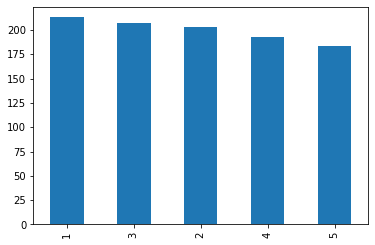

In [5]:
train['class_index'].value_counts().plot(kind='bar')

As the dataset creators have told us, the training dataset consists of 600 thousand samples for each review score, from 1 to 5.

##### Most frequent Words

/home/joao/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Occurrencies')]

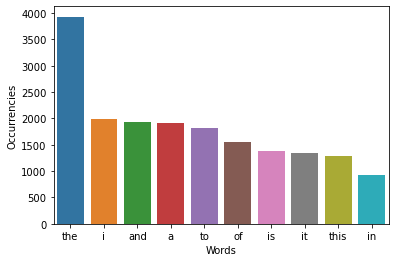

In [6]:
from collections import Counter

mostUsed = pd.Series(' '.join(train['review_text']).lower().split()).value_counts()[:10]
mostUsedGraph = sb.barplot(mostUsed.index, mostUsed.values)
mostUsedGraph.set(xlabel="Words", ylabel="Occurrencies")

### Treating the data
##### Cleanup and Normalization

In [7]:
ps = PorterStemmer()

def normalize(text):
    # remove non alpha chars
    text = re.sub('[^a-zA-Z]', ' ', text)   # TODO: CHECK THIS REGULAR EXPRESSION
    # to lower-case and tokenize
    text = text.lower().split()
    # stemming and stop word removal
    text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])

    return text

train['review_text'] = train['review_text'].apply(normalize)
train['review_title'] = train['review_title'].apply(normalize)
train.head()

test['review_text'] = test['review_text'].apply(normalize)
test['review_title'] = test['review_title'].apply(normalize)

##### Saving Preprocessed data
Since the original dataset is very large, we can sample it and save the preprocessed data in a different csv file, so it can be used later.

In [8]:
def savePreprocessedData(dataSet, fileName):
    dataSet.to_csv(fileName, index=False)

savePreprocessedData(train, './data/train_preprocessed.csv')
savePreprocessedData(test, './data/test_preprocessed.csv')

##### Generating wordclouds
A visually appealing way of observing words in a dataset is by showing wordclouds. In order to make a single wordcloud for a whole column, we can join all the cells together. We then pass it to WordCloud to generate a wordcloud: it will automatically assign weights to words based on the number of occurrences of each word.

These are the most common words in the reviews' titles:

In [ ]:
wordcloudTitle = WordCloud().generate(" ".join([str(x) for x in train['review_title'].values]))

plt.figure()
plt.imshow(wordcloudTitle)
plt.axis('off')
plt.show()

These are the most common words in the reviews' text:

In [ ]:
wordcloudText = WordCloud().generate(" ".join([str(x) for x in train['review_text'].values]))

plt.figure()
plt.imshow(wordcloudText)
plt.axis('off')
plt.show()

It would also be interesting to visualize a wordcloud for each of the reviews' classes (1 to 5):

In [ ]:
wordsPerClass = {
    1: ("", ""), # title and text
    2: ("", ""),
    3: ("", ""),
    4: ("", ""),
    5: ("", ""),
}

for i in range(len(train)):
    classId = train['class_index'].values[i]
    titleWords = train['review_title'].values[i]
    textWords = train['review_text'].values[i]
    
    wordsPerClass[classId] = (wordsPerClass[classId][0] + titleWords, wordsPerClass[classId][1] + textWords)

for i in range(1, 6):
    # Word cloud for class's titles
    wordcloudTitle = WordCloud().generate(wordsPerClass[i][0])
    print(f"Word cloud for class {i}'s titles:")

    plt.figure()
    plt.imshow(wordcloudTitle)
    plt.axis('off')
    plt.show()

    # Word cloud for class's text
    wordcloudText = WordCloud().generate(wordsPerClass[i][1])
    print(f"Word cloud for class {i}'s text:")

    plt.figure()
    plt.imshow(wordcloudText)
    plt.axis('off')
    plt.show()

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [ ]:
train = pd.read_csv('./data/train_preprocessed.csv')
test = pd.read_csv('./data/test_preprocessed.csv')

vectorizer = CountVectorizer()

trainArr = list(map(str, train['review_title']))

titleWords = vectorizer.fit_transform(trainArr).toarray()

print(titleWords.shape)
print(vectorizer.get_feature_names())

### Obtaining the Test classes

In [25]:
y = train['class_index']

# print(X.shape, y.shape)

### Training Classifiers

In [46]:
clf = MultinomialNB()
clf.fit(titleWords, y)

testArr = list(map(str, test['review_title']))
testVector = vectorizer.transform(testArr).toarray()

y_pred = clf.predict(testVector)
print(y_pred)

[4 3 2 1 3 1 1 2 1 5 4 3 1 3 4 5 1 1 2 4 3 1 1 3 5 3 1 4 3 3 4 3 3 5 1 4 1
 2 4 4 3 4 1 1 2 5 1 2 3 1 3 4 5 5 3 3 1 5 3 3 1 3 1 1 1 3 4 5 3 5 4 3 3 1
 4 4 5 5 2 3 4 5 4 5 5 4 3 1 2 4 1 3 2 1 1 2 2 1 1 4 4 3 5 2 3 1 4 1 1 1 4
 5 4 1 2 4 1 1 3 1 1 4 4 1 5 1 3 1 2 3 4 2 2 5 5 1 3 1 4 1 5 1 1 1 1 4 1 3
 4 1 1 3 4 3 1 1 5 2 2 4 4 1 2 1 1 1 1 5 5 1 2 4 1 2 4 3 1 1 3 4 3 1 2 1 5
 2 2 1 1 2 4 5 1 3 4 5 3 5 5 1 1 4 4 1 5 1 4 5 1 1 3 2 3 3 2 1]


### Analyse Results

In [48]:
# confusion matrix
confusionMatrix = confusion_matrix(test['class_index'], y_pred)
print(confusionMatrix)
tp = confusionMatrix[0][0]
fn = confusionMatrix[0][1]
fp = confusionMatrix[1][0]
tn = confusionMatrix[1][1]

accuracy = (tn+tp)/(tp+fn+fp+tn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision*recall) / (precision + recall)
# accuracy, precision, recall, f1
# your code here
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

[[24  1  1  5  4]
 [13 11 13  8  3]
 [19  6 17  8  5]
 [ 7  5  8 11  8]
 [10  4  4 10 11]]
Accuracy: 0.7142857142857143
Precision: 0.6486486486486487
Recall: 0.96
F1: 0.7741935483870968
